# Final Project, Sentiment Analysis Amazon Dataset
## Predict Sentiment from Textual Data in order to improve and develop PR for companies 
### Business Plan:
* We are an organisation that helps and gives Business effective advice on improving their PR.
* I work as part of a team within the organisation that deals with textual data that has been scraped off of social media and we analyse and seek to gain insight from the text about the company or their products/services and based on our analysis give advice and areas of improvement for the company

In [49]:
#custom library with functions i made
import Functions as func

#basic pandas and visualisation loibraries
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
pd.set_option('display.width', 1000)
import numpy as np
import re

#text preprocessing and cleaning libraries
from string import punctuation
from collections import Counter
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import stopwords

# sklearn libraries
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, auc, roc_curve, f1_score, precision_score, recall_score 
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

#Pytorch
import torch

#keras libraries
from keras.layers import Dense, Embedding
from keras import Sequential
from keras.layers import LSTM
from keras import layers
from keras import models
from keras import metrics
from keras.utils.np_utils import to_categorical
from keras import losses
from keras import optimizers
from keras.utils.np_utils import to_categorical
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.text import text_to_word_sequence
from keras.preprocessing.sequence import pad_sequences
from keras import backend as K

# NLP
from nltk.tokenize import casual_tokenize
from nltk.stem.porter import PorterStemmer

In [50]:
df = pd.read_csv('train.csv', nrows=400000, header=None)

In [51]:
df.head()

,0,1,2
0,3,more like funchuck,Gave this to my dad for a gag gift after direc...
1,5,Inspiring,I hope a lot of people hear this cd. We need m...
2,5,The best soundtrack ever to anything.,I'm reading a lot of reviews saying that this ...
3,4,Chrono Cross OST,The music of Yasunori Misuda is without questi...
4,5,Too good to be true,Probably the greatest soundtrack in history! U...


In [53]:
df.rename({0: 'star', 1:'rating1', 2:'rating2'}, axis=1, inplace=True)
df['review'] = df['rating1'] + ' ' + df['rating2']
df.drop(columns=['rating1', 'rating2'],inplace=True)


# Dropping neutral(3 star rating) reviews
df = df.set_index('star')
df = df.drop([3])
df = df.reset_index()
# making reviews 4 and above as 1(positive) and the rest as 0(negative)
df['star'] = df['star'].apply(lambda x: 1 if x >=4 else 0)
df['review'] = df['review'].apply(func.cleanup)

In [54]:
df.describe()

,star
count,319191.000000
mean,0.504463
std,0.499981
min,0.000000
25%,0.000000
50%,1.000000
75%,1.000000
max,1.000000


0    49.553715
1    50.446285
Name: star, dtype: float64


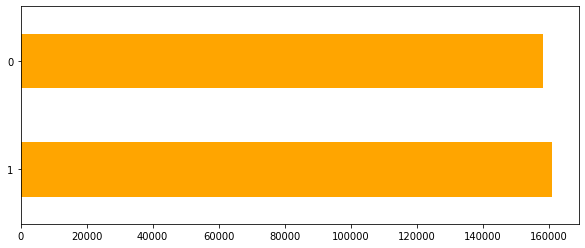

In [55]:
# distribution of review, evenly spread between positve and negative
df['star'].value_counts().plot(kind='barh',figsize=(10,4), color='orange')
print(df['star'].value_counts(normalize=True, ascending=True) * 100)

In [58]:
# Cleaned df
# df.to_csv('cleaned.csv')

#### Will only use a subset of 300k 

In [9]:
reviews = df['review'].apply(lambda x: x.lower())
#removing punctuation and splitting
reviews = reviews.apply(lambda x: re.sub(r'[^\w\s]', '',x))
reviews = reviews.apply(lambda x: x.split(' '))
reviews = reviews[:300000]
reviews

0         [inspiring, i, hope, a, lot, of, people, hear,...
1         [the, best, soundtrack, ever, to, anything, im...
2         [chrono, cross, ost, the, music, of, yasunori,...
3         [too, good, to, be, true, probably, the, great...
4         [theres, a, reason, for, the, price, theres, a...
                                ...                        
299995    [great, last, minute, review, if, you, need, a...
299996    [contracts, my, emanuel, came, right, in, time...
299997    [crunch, time, , contracts, this, was, such, a...
299998    [just, okay, there, is, too, much, in, this, b...
299999    [law, school, purchased, this, for, my, daught...
Name: review, Length: 300000, dtype: object

In [10]:
reviews2 = df['star'].apply(lambda x: str(x))
reviews2 = df['review'].apply(lambda x: re.sub(r'[^\w\s]', '',x))
reviews2 = reviews2[:300000]
#will be used for EDA
reviews2

0         inspiring i hope a lot of people hear this cd ...
1         the best soundtrack ever to anything im readin...
2         chrono cross ost the music of yasunori misuda ...
3         too good to be true probably the greatest soun...
4         theres a reason for the price theres a reason ...
                                ...                        
299995    great last minute review if you need a quick l...
299996    contracts my emanuel came right in time to hel...
299997    crunch time  contracts this was such a helpful...
299998    just okay there is too much in this book to he...
299999    law school purchased this for my daughter for ...
Name: review, Length: 300000, dtype: object

In [11]:
labels = df['star']
labels = labels[:300000]
labels

0         1
1         1
2         1
3         1
4         1
         ..
299995    1
299996    1
299997    1
299998    0
299999    1
Name: star, Length: 300000, dtype: int64

,0,1,2
0,3,more like funchuck,Gave this to my dad for a gag gift after direc...
1,5,Inspiring,I hope a lot of people hear this cd. We need m...
2,5,The best soundtrack ever to anything.,I'm reading a lot of reviews saying that this ...
3,4,Chrono Cross OST,The music of Yasunori Misuda is without questi...
4,5,Too good to be true,Probably the greatest soundtrack in history! U...


## EDA on our Data

In [12]:
#creating Counters for each rating and a total_counts to count words that appear in reviews
positive_counts = Counter()
negative_counts = Counter()

total_counts = Counter()

for i in range(len(reviews)):
    if (labels[i] == 1):
        for word in reviews[i]:
            positive_counts[word] += 1
            total_counts[word] += 1
    else:
        for word in reviews[i]:
            negative_counts[word] += 1
            total_counts[word] +=1

In [13]:
# Create Counter object to store positive/negative ratios
positive_ratios = Counter()
negative_ratios = Counter()
pos_neg_ratios = Counter()

#Calculating the ratios of words for each label against all words
for term, cnet in list(total_counts.most_common()):
    if (cnet > 100):
        negative_ratio = negative_counts[term]/ float(total_counts[term] +1)
        posititve_ratio = positive_counts[term]/ float(total_counts[term] +1)
        pos_neg_ratio = positive_counts[term]/ float(negative_counts[term] + 1)
        
        negative_ratios[term] = negative_ratio
        positive_ratios[term] = posititve_ratio
        pos_neg_ratios[term] = pos_neg_ratio

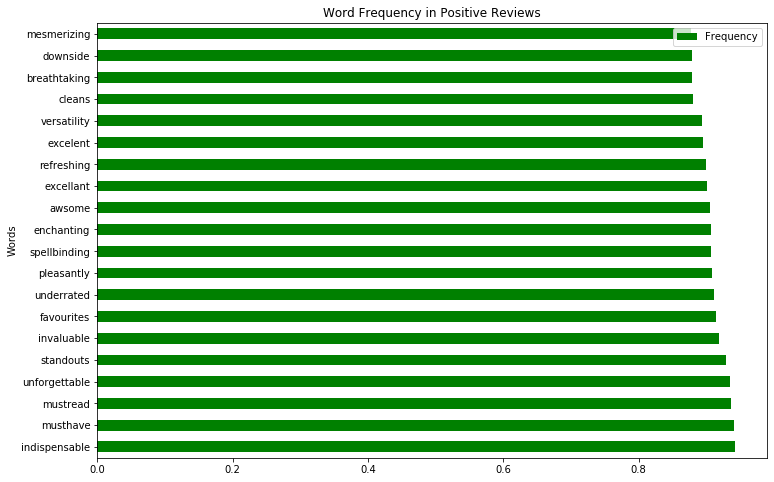

In [14]:
# 20 most common words found in positive reviews
positive = positive_ratios.most_common()[:20]
positive = pd.DataFrame(positive)
positive = positive.rename({0:'Words', 1: "Frequency"}, axis=1)
positive
positive.set_index('Words').plot(kind='barh',
                           figsize=(12, 8),
                           color = 'green',
                           title="Word Frequency in Positive Reviews" )
# you can see words that are assosiciated with positive reviews are words such as 'mesmerizing','awsome' and so on

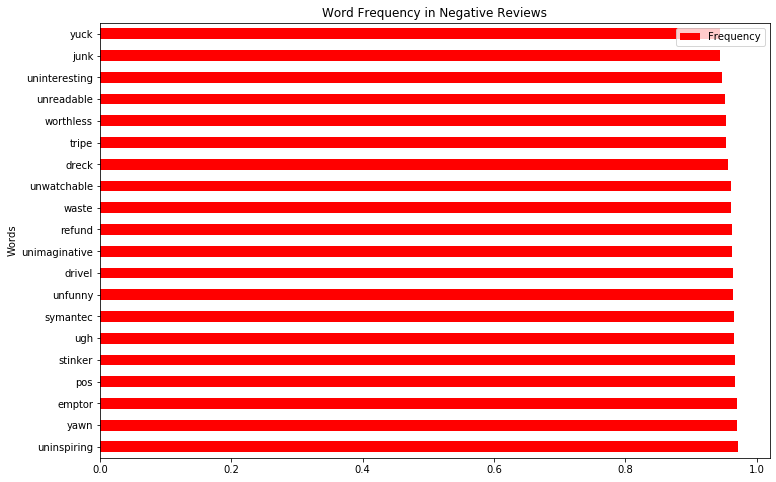

In [15]:
# Top 20 most common words found in negative reviews
negative = negative_ratios.most_common()[:20]
negative = pd.DataFrame(negative)
negative = negative.rename({0:'Words', 1: "Frequency"}, axis=1)
negative
negative.set_index('Words').plot(kind='barh',
                           figsize=(12, 8),
                           color = 'red',
                           title="Word Frequency in Negative Reviews" )
# # you can see words that are assosiciated with negative reviews are words such as 'refund', 'junk' and so on

In [17]:
# finding the number of unique words from all reviews
unique_words = set(total_counts)
len(unique_words)

397752

In [ ]:
# this step is used to create a list of all words in reviews for later when we create a vocab dictionary to map words to
# integers for computer processing
joined_reviews = []
for review in reviews2:
    joined_reviews.append(review)
    
# makes all reviews into 1 big blob of text    
all_text = ' '.join(joined_reviews)
# create a list of words
words = all_text.split()

In [20]:
len(words)

24089650

## Preprocessing the Text reviews Column for Sentiment Analysis

In [21]:
# is in string form not in a list
reviews2

0         inspiring i hope a lot of people hear this cd ...
1         the best soundtrack ever to anything im readin...
2         chrono cross ost the music of yasunori misuda ...
3         too good to be true probably the greatest soun...
4         theres a reason for the price theres a reason ...
                                ...                        
299995    great last minute review if you need a quick l...
299996    contracts my emanuel came right in time to hel...
299997    crunch time  contracts this was such a helpful...
299998    just okay there is too much in this book to he...
299999    law school purchased this for my daughter for ...
Name: review, Length: 300000, dtype: object

In [ ]:
# same as above except in a list, used this one for EDA and will use above for the acutal modelling process
reviews

In [23]:
labels

0         1
1         1
2         1
3         1
4         1
         ..
299995    1
299996    1
299997    1
299998    0
299999    1
Name: star, Length: 300000, dtype: int64

In [24]:
# number of words we will keep when running our model
num_words = 50000

In [25]:
tokenize = Tokenizer(num_words=num_words, # vocab consists of only 50000 most important words
               filters='!"#$%&()*+,-./:;<=>?@[\]^_`{"}~\t\n', # Regex that will prune off non alphabetical characters
               split=" ")
tokenize.fit_on_texts(reviews) # Fit on our training set
reviews_seq = tokenize.texts_to_sequences(reviews) # Indexed sequences, putting words into integers
reviews_seq_pad = pad_sequences(reviews_seq, maxlen = 200) # making sure length of each review is equal
features_encoded = reviews_seq_pad

In [26]:
len(features_encoded)

300000

In [27]:
print(reviews_seq[0])
print('\n')
print(features_encoded[0])

[2083, 4, 385, 3, 168, 6, 126, 390, 8, 90, 80, 205, 49, 587, 2, 1076, 12479, 29, 8, 32, 936, 1108, 1274, 28168, 3743, 70, 1300, 9, 38, 1, 8616, 1, 611, 389, 23, 1384, 2, 2468]


[    0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0 

In [28]:
labels_encoded = np.array(labels)
print(labels_encoded)
len(labels_encoded)

[1 1 1 ... 1 0 1]


300000

## Train/Val/Test Split

In [29]:
split_frac = 0.8

## split data into training, validation, and test data for features and labels
#splitting 80% training, 20% testing
split_idx = int(len(reviews)*0.8)
X_train, remaining_x = reviews_seq_pad[:split_idx], reviews_seq_pad[split_idx:]
y_train, remaining_y = labels_encoded[:split_idx], labels_encoded[split_idx:]

#splitting the remaining 20% testing data into 10% validation and 10% test
test_idx = int(len(remaining_x)*0.5)
test_idx_y = int(len(remaining_y)*0.5)
X_val, X_test = remaining_x[:test_idx], remaining_x[test_idx:]
y_val, y_test = remaining_y[:test_idx], remaining_y[test_idx:]

## the Shapes of our training/validation/testing data for features and labels
print("\t\t\tFeature Shapes:")
print("Train set: \t\t{}".format(X_train.shape), 
      "\nValidation set: \t{}".format(X_val.shape),
      "\nTest set: \t\t{}".format(X_test.shape))
print('\n')
print("\t\t\tLabels Shapes:")
print("Train set:              {}".format(y_train.shape), 
      "\nValidation set:         {}".format(y_val.shape),
      "\nTest set:               {}".format(y_test.shape))

			Feature Shapes:
Train set: 		(240000, 200) 
Validation set: 	(30000, 200) 
Test set: 		(30000, 200)


			Labels Shapes:
Train set:              (240000,) 
Validation set:         (30000,) 
Test set:               (30000,)


In [30]:
print(X_train)
print(len(X_train))

[[    0     0     0 ...  1384     2  2468]
 [    0     0     0 ...   162   163  2921]
 [    0     0     0 ...     2   152   241]
 ...
 [    0     0     0 ...    18  1287  2030]
 [    0     0     0 ...    47  2361 10236]
 [    0     0     0 ...  1050   184  7204]]
240000


In [31]:
print(y_train)
print(len(y_train))

[1 1 1 ... 1 0 0]
240000


## DataLoaders and Batching 
using it to feed my data 100 reviews at a time

In [32]:
import torch
from torch.utils.data import TensorDataset, DataLoader

# making into Tensor datasets
train_data = TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train))
valid_data = TensorDataset(torch.from_numpy(X_val), torch.from_numpy(y_val))
test_data = TensorDataset(torch.from_numpy(X_test), torch.from_numpy(y_test))

# dataloaders, this is how many reviews we will be passing into our model at a time
batch_size = 200

train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=batch_size)
test_loader = DataLoader(test_data, shuffle=True, batch_size=batch_size)

In [33]:
# so we can see how many steps for each epoch
counter = 0
for inputs, labels in train_loader:
        counter += 1
print(counter)

1200


In [34]:

dataiter = iter(train_loader)
sample_x, sample_y = dataiter.next()

print('Sample input size: ', sample_x.size()) # batch_size, seq_length
print('Sample input: \n', sample_x)
print()
print('Sample label size: ', sample_y.size()) # batch_size
print('Sample label: \n', sample_y)
# telling us we are taking 200 batches of reviews at a time and they contain 200 values each one representing either
# a 0 which is padding or an integer that maps to a word

Sample input size:  torch.Size([200, 200])
Sample input: 
 tensor([[   0,    0,    0,  ...,   10,  171,  341],
        [   0,    0,    0,  ...,  238,    6,   76],
        [   0,    0,    0,  ...,    8, 1471, 1042],
        ...,
        [   0,    0,    0,  ...,   27, 1211,   90],
        [   0,    0,    0,  ...,    4,  115,   76],
        [   0,    0,    0,  ...,    9, 1735,  279]], dtype=torch.int32)

Sample label size:  torch.Size([200])
Sample label: 
 tensor([1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0,
        0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0,
        1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0,
        1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1,
        1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0,
        1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0,
        1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0,

In [35]:
train_on_gpu=torch.cuda.is_available()

if(train_on_gpu):
    print('Training on GPU.')
else:
    print('No GPU available, training on CPU.')

No GPU available, training on CPU.


In [36]:
import torch.nn as nn

class SentimentRNN(nn.Module):
    """
    The RNN model that will be used to perform Sentiment analysis.
    """

    def __init__(self, vocab_size, output_size, embedding_dim, hidden_dim, n_layers, drop_prob=0.5):
        """
        Initialize the model by setting up the layers.
        """
        super(SentimentRNN, self).__init__()

        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        
        # embedding and LSTM layers
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers, 
                            dropout=drop_prob, batch_first=True)
        
        # dropout layer
        self.dropout = nn.Dropout(0.3)
        
        # linear and sigmoid layers
        self.fc = nn.Linear(hidden_dim, output_size)
        self.sig = nn.Sigmoid()
        

    def forward(self, x, hidden):
        """
        Perform a forward pass of our model on some input and hidden state.
        """
        batch_size = x.size(0)

        # embeddings and lstm_out
        x = x.long()
        embeds = self.embedding(x)
        lstm_out, hidden = self.lstm(embeds, hidden)
    
        # stack up lstm outputs
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim)
        
        # dropout and fully-connected layer
        out = self.dropout(lstm_out)
        out = self.fc(out)
        # sigmoid function
        sig_out = self.sig(out)
        
        # reshape to be batch_size first
        sig_out = sig_out.view(batch_size, -1)
        sig_out = sig_out[:, -1] # get last batch of labels
        
        # return last sigmoid output and hidden state
        return sig_out, hidden
    
    
    def init_hidden(self, batch_size):
        ''' Initializes hidden state '''
        # Create two new tensors with sizes n_layers x batch_size x hidden_dim,
        # initialized to zero, for hidden state and cell state of LSTM
        weight = next(self.parameters()).data
        
        if (train_on_gpu):
            hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().cuda(),
                  weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().cuda())
        else:
            hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_(),
                      weight.new(self.n_layers, batch_size, self.hidden_dim).zero_())
        
        return hidden

In [38]:
vocab_size = num_words +1 # +1 for the 0 padding + our word tokens
output_size = 1 # will be either 1 for positive and 0 for negative
embedding_dim = 400
hidden_dim = 256
n_layers = 2

net = SentimentRNN(vocab_size, output_size, embedding_dim, hidden_dim, n_layers)

print(net)

SentimentRNN(
  (embedding): Embedding(50001, 400)
  (lstm): LSTM(400, 256, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (sig): Sigmoid()
)


Training the model with Binary-Cross Entropy as our outcome is either 1, for positive reviews or 0 for negative reviews, we will be using a learning rate of 0.01 to ensure that the model takes small steps towards optimizing the accuracy of our model

In [39]:
lr = 0.01
criterion = nn.BCELoss() # Binary-cross entropy loss
optimizer = torch.optim.Adam(net.parameters(), lr=lr) # using an adam optimizer

### Training our Model

In [40]:
# # training params

# epochs = 2 
# counter = 0
# print_every = 100
# clip=5 # gradient clipping so gradient doesnt explode

# # move model to GPU, if available
# if(train_on_gpu):
#     net.cuda()

# net.train()
# # train for some number of epochs
# for e in range(epochs):
#     # initialize hidden state
#     h = net.init_hidden(batch_size)

#     # batch loop
#     for inputs, labels in train_loader:
#         counter += 1

#         if(train_on_gpu):
#             inputs, labels = inputs.cuda(), labels.cuda()

#         # Creating new variables for the hidden state, otherwise
#         # we'd backprop through the entire training history
#         h = tuple([each.data for each in h])

#         # zero accumulated gradients
#         net.zero_grad()

#         # get the output from the model
#         output, h = net(inputs, h)

#         # calculate the loss and perform backprop
#         loss = criterion(output.squeeze(), labels.float())
#         loss.backward()
#         # `clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
#         nn.utils.clip_grad_norm_(net.parameters(), clip)
#         optimizer.step()

#         # loss stats
#         if counter % print_every == 0:
#             # Get validation loss
#             val_h = net.init_hidden(batch_size)
#             val_losses = []
#             net.eval()
#             for inputs, labels in valid_loader:

#                 # Creating new variables for the hidden state, otherwise
#                 # we'd backprop through the entire training history
#                 val_h = tuple([each.data for each in val_h])

#                 if(train_on_gpu):
#                     inputs, labels = inputs.cuda(), labels.cuda()

#                 output, val_h = net(inputs, val_h)
#                 val_loss = criterion(output.squeeze(), labels.float())

#                 val_losses.append(val_loss.item())

#             net.train()
#             print("Epoch: {}/{}...".format(e+1, epochs),
#                   "Step: {}...".format(counter),
#                   "Loss: {:.6f}...".format(loss.item()),
#                   "Val Loss: {:.6f}".format(np.mean(val_losses)))


## Testing our Model on testing dataset

In [41]:
# # Get test data loss and accuracy

# test_losses = [] # track loss
# num_correct = 0

# # init hidden state
# h = net.init_hidden(batch_size)

# net.eval()
# # iterate over test data
# for inputs, labels in test_loader:

#     # Creating new variables for the hidden state, otherwise
#     # we'd backprop through the entire training history
#     h = tuple([each.data for each in h])

#     if(train_on_gpu):
#         inputs, labels = inputs.cuda(), labels.cuda()
    
#     # get predicted outputs
#     output, h = net(inputs, h)
    
#     # calculate loss
#     test_loss = criterion(output.squeeze(), labels.float())
#     test_losses.append(test_loss.item())
    
#     # convert output probabilities to predicted class (0 or 1)
#     pred = torch.round(output.squeeze())  # rounds to the nearest integer
    
#     # compare predictions to true label
#     correct_tensor = pred.eq(labels.float().view_as(pred))
#     correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
#     num_correct += np.sum(correct)


# # -- stats -- ##
# # avg test loss
# print("Test loss: {:.3f}".format(np.mean(test_losses)))

# # accuracy over all test data
# test_acc = num_correct/len(test_loader.dataset)
# print("Test accuracy: {:.3f}".format(test_acc))

### Actually Testing our model with completly new fed text

In [42]:
#saving our model parameters
# torch.save(net.state_dict(), 'model2-300k.pth')

In [43]:

print("Our model: \n\n", net, '\n')
print("The state dict keys: \n\n", net.state_dict().keys())


Our model: 

 SentimentRNN(
  (embedding): Embedding(50001, 400)
  (lstm): LSTM(400, 256, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (sig): Sigmoid()
) 

The state dict keys: 

 odict_keys(['embedding.weight', 'lstm.weight_ih_l0', 'lstm.weight_hh_l0', 'lstm.bias_ih_l0', 'lstm.bias_hh_l0', 'lstm.weight_ih_l1', 'lstm.weight_hh_l1', 'lstm.bias_ih_l1', 'lstm.bias_hh_l1', 'fc.weight', 'fc.bias'])


In [44]:
#loading our model in
state_dict = torch.load('model2-300k.pth')
print(state_dict.keys())

odict_keys(['embedding.weight', 'lstm.weight_ih_l0', 'lstm.weight_hh_l0', 'lstm.bias_ih_l0', 'lstm.bias_hh_l0', 'lstm.weight_ih_l1', 'lstm.weight_hh_l1', 'lstm.bias_ih_l1', 'lstm.bias_hh_l1', 'fc.weight', 'fc.bias'])


In [45]:
net.load_state_dict(state_dict)

<All keys matched successfully>

In [47]:
top_words = total_counts.most_common()

words[0][0]
words = []
for word in top_words:
    words.append(word[0])
vocab2index = {word: ii for ii, word in enumerate(words, 1)}

In [48]:
from string import punctuation
#Tokenize Function
def tokenize_review(test_review):
    test_review = test_review.lower() # lowercase
    # get rid of punctuation
    test_text = ''.join([c for c in test_review if c not in punctuation])

    # splitting
    test_words = test_text.split()

    # Tokenize and indexing
    test_ints = [] 
    test_ints.append([vocab2index[word] if word in list(vocab2index.keys()) else 0 for word in test_words])   
    
    return test_ints


# Predict Functions
def predict(net, test_review, sequence_length=200):
    
    net.eval()
    
    # tokenize review
    test_ints = tokenize_review(test_review)
    
    # pad tokenized sequence
    seq_length=sequence_length
    features = pad_sequences(test_ints, seq_length)
    
    # convert to tensor to pass into model
    feature_tensor = torch.from_numpy(features)
    
    batch_size = feature_tensor.size(0)
    
    # initialize hidden state
    h = net.init_hidden(batch_size)
    
    if(train_on_gpu):
        feature_tensor = feature_tensor.cuda()
    
    # get the output from the model
    output, h = net(feature_tensor, h)
    
    # converting output probabilities to predicted class (0 or 1)
    pred = torch.round(output.squeeze()) 
    # printing output value, before rounding to see strength of prediction 
    print('Prediction value, pre-rounding: {:.6f}'.format(output.item()))
    
    # print custom response
    if(pred.item()==1):
        print("Positive review detected!")
    else:
        print("Negative review detected.")
        

In [49]:
test_review = 'I though the movie was great, but I didnt lik Nick Cage as ghost rider'

In [50]:
seq_length=200

predict(net, test_review, seq_length)

Prediction value, pre-rounding: 0.647561
Positive review detected!


# <h1><center>__<font color=blue>User Experience! </font>__ </center></h1>
![sentiment](img/sentiment.png)
<!-- <font color=blue|red|green|pink|yellow>Text</font> -->
#####  <h1><center><font color = black>input a test review of any length between the <font color = red>two red</font> Apostrophe</font></center></h1>
#####  <h1><center><font color = black>tell me what sentiment you think that your review be?(is it <font color = blue>positive</font> or <font color = red>negative?</font>)</font></center></h1>

In [ ]:
review = input('Your Review:')
predict(net, review, seq_length)